In [1]:
!pip install pymorphy2
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import itertools
from functools import partial
import re
import string

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import pymorphy2

from gensim.corpora.dictionary import Dictionary 
from gensim.models import LdaModel, LsiModel, TfidfModel

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=ccf15475a91f342fb65b6f868fb078056e7cbbd89764da54f9d61ec45ae1f14c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
uploaded = files.upload() #просто запускаем и выбираем файл в проводнике

#↓ строка которая активирует наш API токен
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c tonality-reviews

 60% 10.0M/16.7M [00:00<00:00, 39.5MB/s]
100% 16.7M/16.7M [00:00<00:00, 61.9MB/s]


In [4]:
!unzip tonality-reviews.zip

Archive:  tonality-reviews.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Препроцессинг

In [5]:
train_df = pd.read_pickle("train.csv")
test_df = pd.read_pickle("test.csv").to_frame()
train_df.head()

,Text,Score
0,"Итак, начнем с того, что решила я оформить кре...",Negative
1,Сначала было все банально. Взял в кредит mp3 п...,Negative
2,"Закрыл сегодня в Бинбанк-онлайн пару вкладов, ...",Negative
3,"Прошла неделя после объединения ББ столица, од...",Negative
4,11.01.2016 при посещение отделения банка по ад...,Negative


Positive    8018
Negative    7981
Name: Score, dtype: int64

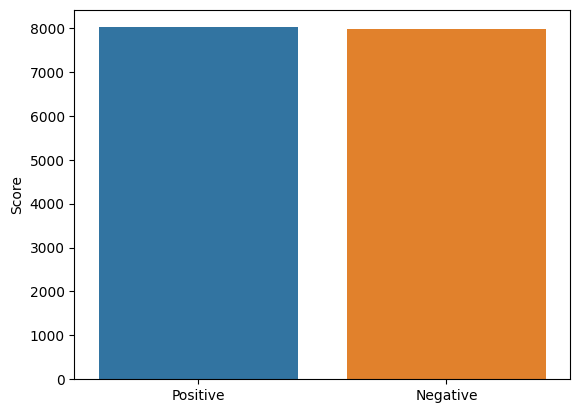

In [6]:
target_values = train_df['Score'].value_counts()
sns.barplot(y = target_values, x = target_values.index)
target_values

Классы сбалансированны

#Предобработка

In [7]:
morph = pymorphy2.MorphAnalyzer()
# убрать ссылки
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r' ',text)

# убрать HTML разметку
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r' ',text)

# убрать эмодзи
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)

# напишем нашу функцию токенизации, с учетом всего рассмотренного
stop_words = set(stopwords.words("russian"))
def mytokenize(text, normalize=None, stop_words=stop_words):
    text = remove_html(text)
    text = remove_URL(text)
    text = remove_emoji(text)
    text = text.lower()
    text = re.sub("[^а-яёйa-z0-9]", " ", text)
    text = re.sub("\s+", " ", text)
    text = word_tokenize(text)
    text = [word for word in text if word.isalpha()]
    text = [word for word in text if not word in stop_words]
    if normalize == "s":
        text = [porter.stem(word) for word in text]
    if normalize == "l":
        text = [morph.normal_forms(word)[0] for word in text]
    return text

from functools import partial

mytokenize_s = partial(mytokenize, normalize='s')
mytokenize_l = partial(mytokenize, normalize='l')

# убрать пунктуацию. В целом при токенизации и очитске от "неслов" вы и так уже от нее избавитесь
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

train_df['tokens'] = train_df['Text'].apply(mytokenize_l)
test_df['tokens'] = test_df['Text'].apply(mytokenize_l)

In [8]:
def join_list(tab):
    return " ".join(tab)
train_df["text_preprocessed"] = train_df["tokens"].apply(join_list)
test_df["text_preprocessed"] = test_df["tokens"].apply(join_list)

In [9]:
train_df.head()

,Text,Score,tokens,text_preprocessed
0,"Итак, начнем с того, что решила я оформить кре...",Negative,"[итак, начать, решить, оформить, кредитный, ка...",итак начать решить оформить кредитный карта мо...
1,Сначала было все банально. Взял в кредит mp3 п...,Negative,"[сначала, банально, взять, кредит, плеер, мес,...",сначала банально взять кредит плеер мес платит...
2,"Закрыл сегодня в Бинбанк-онлайн пару вкладов, ...",Negative,"[закрыть, сегодня, бинбанк, онлайн, пара, вкла...",закрыть сегодня бинбанк онлайн пара вклад день...
3,"Прошла неделя после объединения ББ столица, од...",Negative,"[пройти, неделя, объединение, бб, столица, одн...",пройти неделя объединение бб столица однако би...
4,11.01.2016 при посещение отделения банка по ад...,Negative,"[посещение, отделение, банк, адрес, спб, наб, ...",посещение отделение банк адрес спб наб обводны...


In [10]:
test_df.head()

,Text,tokens,text_preprocessed
0,"Добрый день, являюсь клиентом банка всего 3 ме...","[добрый, день, являться, клиент, банк, месяц, ...",добрый день являться клиент банк месяц пользов...
1,Удивлена ленью и некомпетентностью сотрудников...,"[удивить, лень, некомпетентность, сотрудник, т...",удивить лень некомпетентность сотрудник третий...
2,"И все-таки самый худший банк, с которым мне ко...","[таки, самый, плохой, банк, который, либо, при...",таки самый плохой банк который либо приходитьс...
3,Здравствуйте!27 сентября 2014 года я вносил 33...,"[здравствуйте, сентябрь, год, вносить, тыс, ру...",здравствуйте сентябрь год вносить тыс руб банк...
4,Уже больше года являюсь клиентом банка. В цело...,"[год, являться, клиент, банк, целое, впечатлен...",год являться клиент банк целое впечатление оче...


In [11]:
train_df.to_csv('train_lem.csv', index = False)
test_df.to_csv('test_lem.csv', index = False)

# Наиболее частые слова

In [12]:
train_df = pd.read_csv('train_lem.csv')
test_df = pd.read_csv('test_lem.csv')

In [13]:
train_df["tokens"] = train_df["text_preprocessed"].apply(str.split)
test_df["tokens"] = test_df["text_preprocessed"].apply(str.split)

In [14]:
pos_words = np.array(list(itertools.chain.from_iterable(train_df[train_df.Score == 'Positive']['tokens'])))
neg_words = np.array(list(itertools.chain.from_iterable(train_df[train_df.Score == 'Negative']['tokens'])))

In [15]:
print(len(pos_words), len(neg_words))

1095467 1332511


In [16]:
pos_set = set(pos_words)
neg_set = set(neg_words)

In [17]:
unique, counts = np.unique(pos_words, return_counts=True)
pos_d = {'Word': unique, 'Frequency': counts}
pos_df = pd.DataFrame(data=pos_d)
pos_unique = pos_df[~pos_df['Word'].isin(neg_set)].sort_values(['Frequency'], ascending=False)
pos_unique.head()

,Word,Frequency
6810,дельтакредит,288
1420,psb,90
3218,бвк,66
10288,карьерный,66
16666,осб,59


In [18]:
unique, counts = np.unique(neg_words, return_counts=True)
neg_d = {'Word': unique, 'Frequency': counts}
neg_df = pd.DataFrame(data=neg_d)
neg_unique = neg_df[~neg_df['Word'].isin(pos_set)].sort_values(['Frequency'], ascending=False)
neg_unique.head()

,Word,Frequency
1403,sep,69
978,ms,66
20885,роскомнадзор,52
2817,ббкк,51
600,guest,43


In [19]:
common_words = pd.merge(neg_df, pos_df, how='inner', on=['Word']).sort_values(['Frequency_x', 'Frequency_y'], ascending=False)
common_words.head()

,Word,Frequency_x,Frequency_y
946,банк,43168,34358
5152,карта,20981,15062
16226,это,11985,9225
6633,мой,11165,7075
3120,день,11101,7573


<Axes: xlabel='Word', ylabel='Frequency'>

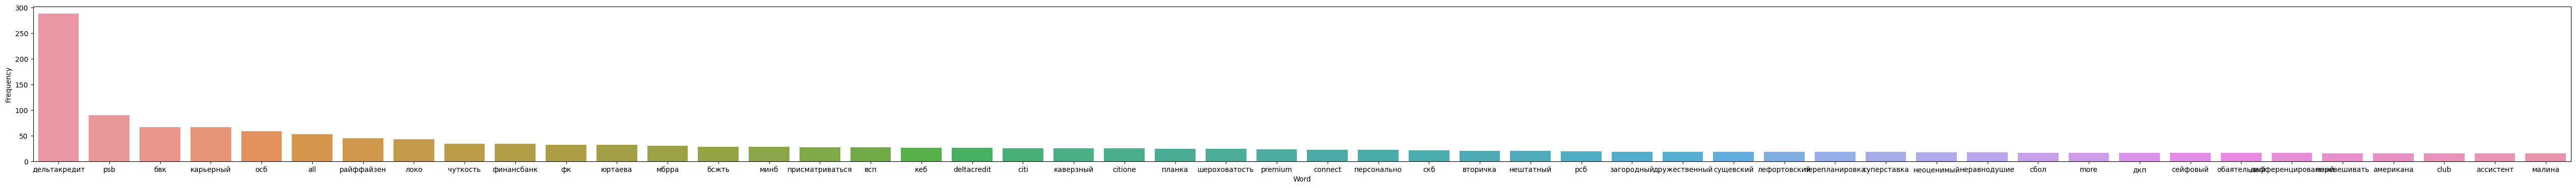

In [20]:
plt.figure(figsize=(65, 4))
sns.barplot(data=pos_unique[:50], x="Word", y="Frequency")

<Axes: xlabel='Word', ylabel='Frequency'>

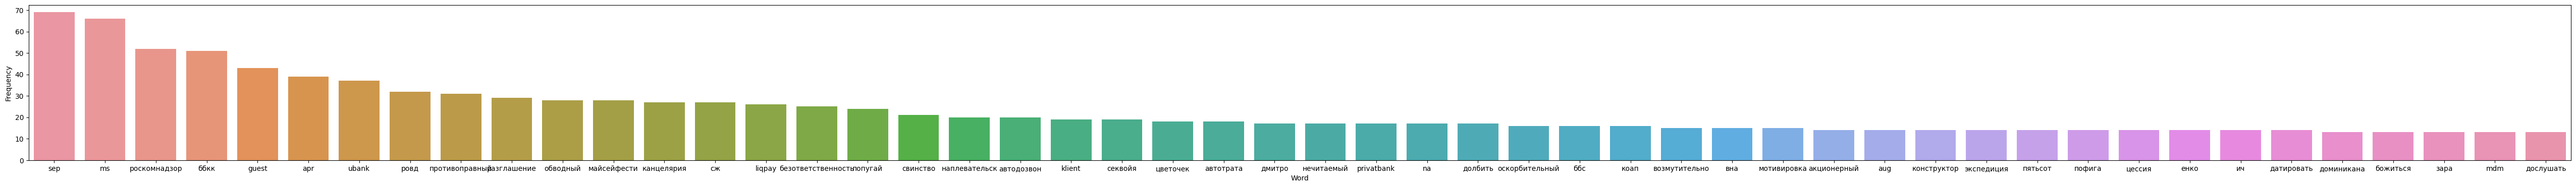

In [21]:
plt.figure(figsize=(65, 4))
sns.barplot(data=neg_unique[:50], x="Word", y="Frequency")

<Axes: xlabel='Word', ylabel='Frequency_x'>

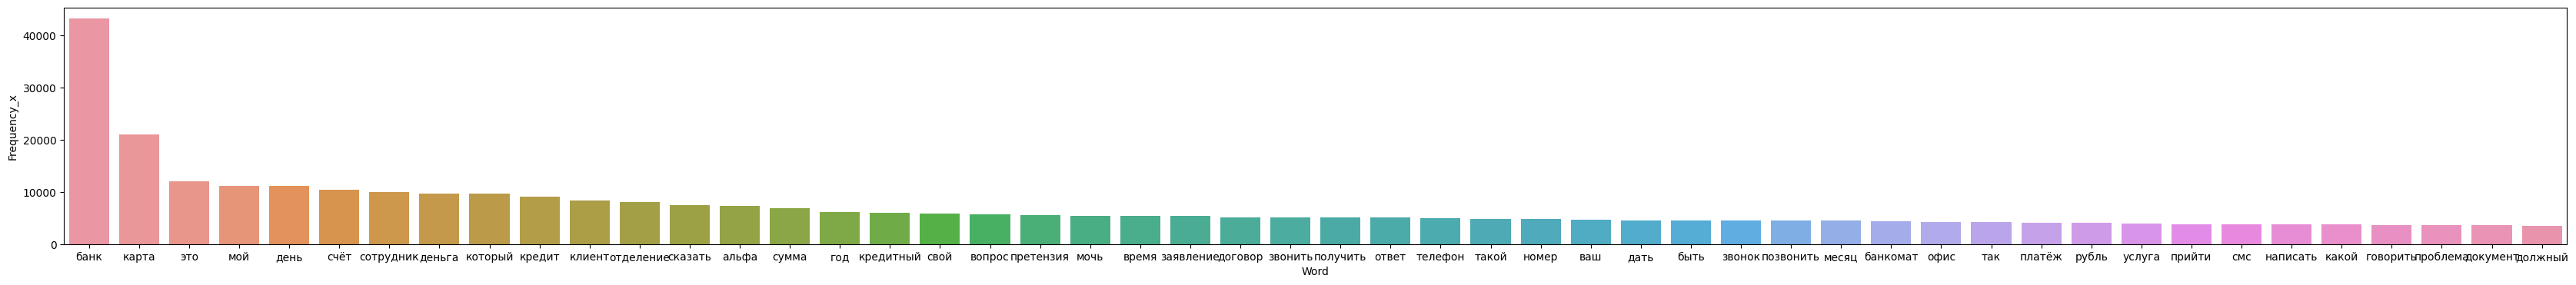

In [22]:
plt.figure(figsize=(42, 4))
sns.barplot(data=common_words[:50], x="Word", y="Frequency_x")

# Векторизация

## Bag of words

In [23]:
swap = {"Negative":0, "Positive":1}
train_df["Score"] = train_df["Score"].replace(swap)

In [24]:
X_all = pd.concat([train_df["text_preprocessed"], test_df["text_preprocessed"]])

sk_doc2bow = CountVectorizer()
sk_doc2bow.fit(X_all)
del X_all
# работаем с не токенизированным текстом
X1 = sk_doc2bow.transform(train_df["text_preprocessed"])
X1_test = sk_doc2bow.transform(test_df["text_preprocessed"])

X1_train, X1_val, y1_train, y1_val = train_test_split(X1, train_df["Score"], test_size=0.1, random_state=54)

## TF-IDF

In [25]:
X_all = pd.concat([train_df["text_preprocessed"], test_df["text_preprocessed"]])

tfidf = TfidfVectorizer()
tfidf.fit(X_all)
del X_all
X2 = tfidf.transform(train_df["text_preprocessed"])
X2_test = tfidf.transform(test_df["text_preprocessed"])

X2_train, X2_val, y2_train, y2_val = train_test_split(X2, train_df["Score"], test_size=0.1, random_state=54)

## LSI

In [26]:
# обратите внимание, что тут уже работае c токенами
X_all = pd.concat([train_df["tokens"], test_df["tokens"]]).reset_index(drop=True)
print(len(X_all))
mydict = Dictionary(X_all)
# создаем корпус на основе doc2bow модели
corpus = [mydict.doc2bow(text) for text in X_all]
# создаем корпус на основе tf_idf модели
tf_model = TfidfModel(corpus)  # тут, при передаче корпуса сразу происходит обучение модели
corpus_tf = tf_model[corpus]  # создаем корпус tf_idf
print(len(corpus_tf))
lsi_model = LsiModel(corpus_tf, id2word=mydict, num_topics=200) # обучаем LSI модель

19999
19999


In [27]:
def make_vec(X, num_top):
    matrix = np.zeros((len(X), num_top))
    for i, row in enumerate(X):
        matrix[i, list(map(lambda tup: tup[0], row))] = list(map(lambda tup: tup[1], row))
    return matrix

def transform(df, tf_model, model):
    corpus = [mydict.doc2bow(text) for text in df]
    corpus = tf_model[corpus]
    corpus = model[corpus]
    corpus = make_vec(corpus, model.num_topics)
    return corpus

In [28]:
print(len(train_df["tokens"]))
X3 = transform(train_df["tokens"], tf_model, lsi_model)
print(len(X3))
X3_test = transform(test_df["tokens"], tf_model, lsi_model)

X3_train, X3_val, y3_train, y3_val = train_test_split(X3, train_df["Score"], test_size=0.1, random_state=42)

15999
15999


## LDA

In [29]:
lda_model = LdaModel(corpus_tf, id2word=mydict, num_topics=100, dtype=np.float64)

In [30]:
print(len(train_df["tokens"]))
X4 = transform(train_df["tokens"], tf_model, lda_model)
print(len(X4))
X4_test = transform(test_df["tokens"], tf_model, lda_model)

X4_train, X4_val, y4_train, y4_val = train_test_split(X4, train_df["Score"], test_size=0.1, random_state=42)

15999
15999


## LSI + LDA

In [31]:
print(len(train_df["tokens"]))
X_1 = transform(train_df["tokens"], tf_model, lda_model)
X_2 = transform(train_df["tokens"], tf_model, lsi_model)
X5 = np.hstack((X_1, X_2))
print(len(X5))

X_1 = transform(test_df["tokens"], tf_model, lda_model)
X_2 = transform(test_df["tokens"], tf_model, lsi_model)
X5_test = np.hstack((X_1, X_2))

X5_train, X5_val, y5_train, y5_val = train_test_split(X5, train_df["Score"], test_size=0.1, random_state=42)
X5_train.shape

15999
15999


(14399, 300)

# Классификация

In [32]:
result = pd.DataFrame(columns = ['Vectorization', 'Classification_model', 'Accuracy'])
result

,Vectorization,Classification_model,Accuracy


## Bag of words

In [33]:
SVC_1 = SVC(C=2, gamma=0.4, kernel='rbf', random_state = 54).fit(X1_train, y1_train)
y_val_pred = SVC_1.predict(X1_val)
result = pd.DataFrame(np.array([['BoW', 'SVC', accuracy_score(y1_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [34]:
RFC_1 = RandomForestClassifier(n_estimators=200, max_depth=None, random_state = 54, n_jobs=-1).fit(X1_train, y1_train)
y_val_pred = RFC_1.predict(X1_val)
result = pd.DataFrame(np.array([['BoW', 'RFC', accuracy_score(y1_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [35]:
GBC_1 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 54).fit(X1_train, y1_train)
y_val_pred = GBC_1.predict(X1_val)
result = pd.DataFrame(np.array([['BoW', 'GBC', accuracy_score(y1_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [36]:
result

,Vectorization,Classification_model,Accuracy
0,BoW,GBC,0.91625
1,BoW,RFC,0.935
2,BoW,SVC,0.49375


## TF-IDF

In [37]:
SVC_2 = SVC(C=2, gamma=0.4, kernel='rbf', random_state = 54).fit(X2_train, y2_train)
y_val_pred = SVC_2.predict(X2_val)
result = pd.DataFrame(np.array([['TF-IDF', 'SVC', accuracy_score(y2_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [38]:
RFC_2 = RandomForestClassifier(n_estimators=200, max_depth=None, random_state = 42, n_jobs=-1).fit(X2_train, y2_train)
y_val_pred = RFC_2.predict(X2_val)
result = pd.DataFrame(np.array([['TF-IDF', 'RFC', accuracy_score(y2_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [39]:
GBC_2 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 42).fit(X2_train, y2_train)
y_val_pred = GBC_2.predict(X2_val)
result = pd.DataFrame(np.array([['TF-IDF', 'GBC', accuracy_score(y2_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [40]:
result

,Vectorization,Classification_model,Accuracy
0,TF-IDF,GBC,0.915625
1,TF-IDF,RFC,0.92625
2,TF-IDF,SVC,0.951875
3,BoW,GBC,0.91625
4,BoW,RFC,0.935
5,BoW,SVC,0.49375


## LSI

In [41]:
SVC_3 = SVC(C=2, gamma=0.4, kernel='rbf', random_state = 42).fit(X3_train, y3_train)
y_val_pred = SVC_3.predict(X3_val)
result = pd.DataFrame(np.array([['LSI', 'SVC', accuracy_score(y3_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [42]:
RFC_3 = RandomForestClassifier(n_estimators=200, max_depth=None, random_state = 42, n_jobs=-1).fit(X3_train, y3_train)
y_val_pred = RFC_3.predict(X3_val)
result = pd.DataFrame(np.array([['LSI', 'RFC', accuracy_score(y3_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [43]:
GBC_3 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 42).fit(X3_train, y3_train)
y_val_pred = GBC_3.predict(X3_val)
result = pd.DataFrame(np.array([['LSI', 'GBC', accuracy_score(y3_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [44]:
result

,Vectorization,Classification_model,Accuracy
0,LSI,GBC,0.92125
1,LSI,RFC,0.905
2,LSI,SVC,0.950625
3,TF-IDF,GBC,0.915625
4,TF-IDF,RFC,0.92625
5,TF-IDF,SVC,0.951875
6,BoW,GBC,0.91625
7,BoW,RFC,0.935
8,BoW,SVC,0.49375


## LDA

In [45]:
SVC_4 = SVC(C=2, gamma=0.4, kernel='rbf', random_state = 42).fit(X4_train, y4_train)
y_val_pred = SVC_4.predict(X4_val)
result = pd.DataFrame(np.array([['LDA', 'SVC', accuracy_score(y4_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [46]:
RFC_4 = RandomForestClassifier(n_estimators=200, max_depth=None, random_state = 42, n_jobs=-1).fit(X4_train, y4_train)
y_val_pred = RFC_4.predict(X4_val)
result = pd.DataFrame(np.array([['LDA', 'RFC', accuracy_score(y4_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [47]:
GBC_4 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 42).fit(X4_train, y4_train)
y_val_pred = GBC_4.predict(X4_val)
result = pd.DataFrame(np.array([['LDA', 'GBC', accuracy_score(y4_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [48]:
result

,Vectorization,Classification_model,Accuracy
0,LDA,GBC,0.7575
1,LDA,RFC,0.7675
2,LDA,SVC,0.771875
3,LSI,GBC,0.92125
4,LSI,RFC,0.905
5,LSI,SVC,0.950625
6,TF-IDF,GBC,0.915625
7,TF-IDF,RFC,0.92625
8,TF-IDF,SVC,0.951875
9,BoW,GBC,0.91625


## LSI + LDA

In [49]:
SVC_5 = SVC(C=2, gamma=0.4, kernel='rbf', random_state = 42).fit(X5_train, y5_train)
y_val_pred = SVC_5.predict(X5_val)
result = pd.DataFrame(np.array([['LSI_LDA', 'SVC', accuracy_score(y5_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [50]:
RFC_5 = RandomForestClassifier(n_estimators=200, max_depth=None, random_state = 42, n_jobs=-1).fit(X5_train, y5_train)
y_val_pred = RFC_5.predict(X5_val)
result = pd.DataFrame(np.array([['LSI_LDA', 'RFC', accuracy_score(y5_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [51]:
GBC_5 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 42).fit(X5_train, y5_train)
y_val_pred = GBC_5.predict(X5_val)
result = pd.DataFrame(np.array([['LSI_LDA', 'GBC', accuracy_score(y5_val, y_val_pred)]]), columns=['Vectorization', 'Classification_model', 'Accuracy']).append(result, ignore_index=True)

In [52]:
result

,Vectorization,Classification_model,Accuracy
0,LSI_LDA,GBC,0.925
1,LSI_LDA,RFC,0.89625
2,LSI_LDA,SVC,0.953125
3,LDA,GBC,0.7575
4,LDA,RFC,0.7675
5,LDA,SVC,0.771875
6,LSI,GBC,0.92125
7,LSI,RFC,0.905
8,LSI,SVC,0.950625
9,TF-IDF,GBC,0.915625


# Результат

In [53]:
result.sort_values('Accuracy', ascending=False)

,Vectorization,Classification_model,Accuracy
2,LSI_LDA,SVC,0.953125
11,TF-IDF,SVC,0.951875
8,LSI,SVC,0.950625
13,BoW,RFC,0.935
10,TF-IDF,RFC,0.92625
0,LSI_LDA,GBC,0.925
6,LSI,GBC,0.92125
12,BoW,GBC,0.91625
9,TF-IDF,GBC,0.915625
7,LSI,RFC,0.905


In [54]:
submission = pd.read_csv("sample_submission.csv")

y_test_pred = SVC_2.predict(X2_test)
submission["Score"] = y_test_pred

swap = {0: "Negative", 1: "Positive"}
submission["Score"] = submission["Score"].replace(swap)

submission.to_csv("sample_submission.csv", index=False)

In [55]:
!kaggle competitions submit -c tonality-reviews -f sample_submission.csv -m "sh!t 1" 

100% 53.6k/53.6k [00:01<00:00, 33.2kB/s]
Successfully submitted to Тональность отзывов об обслуживании

# Модификация TF-IDF

In [56]:
X_all = pd.concat([train_df["text_preprocessed"], test_df["text_preprocessed"]])

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,3))
tfidf.fit(X_all)
del X_all

X = tfidf.transform(train_df["text_preprocessed"])
X_test = tfidf.transform(test_df["text_preprocessed"])

X_train, X_val, y_train, y_val = train_test_split(X, train_df["Score"], test_size=0.1, random_state=42)

In [57]:
SVC_new = SVC(C=10, gamma=0.4, kernel='rbf', random_state = 42).fit(X_train, y_train)
y_val_pred = SVC_new.predict(X_val)
accuracy_score(y_val, y_val_pred)

0.96375

In [58]:
submission = pd.read_csv("sample_submission.csv")

y_test_pred = SVC_new.predict(X_test)
submission["Score"] = y_test_pred

swap = {0: "Negative", 1: "Positive"}
submission["Score"] = submission["Score"].replace(swap)

submission.to_csv("sample_submission.csv", index=False)

In [59]:
!kaggle competitions submit -c tonality-reviews -f sample_submission.csv -m "sh!t 2" 

100% 53.6k/53.6k [00:01<00:00, 42.1kB/s]
Successfully submitted to Тональность отзывов об обслуживании